In [1]:
from bioformers.datasets.ArrowDataset import ArrowDataset
from bioformers.datasets import dataset_utils
from bioformers.utilize.Bert import BertSeqClassification
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import os
import numpy
import warnings 

from transformers import BertModel, BertTokenizer
import re

from datasets import load_dataset
from datasets import Dataset
from datasets import load_from_disk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["TOKENIZERS_PARALLELISM"] = "true"


num_cpu = 16
max_length = 512
lr = '1.81e-5'
num_labels = 8
max_epch = 21
gpu = '4'
min_lr = float(1e-05)
max_lr = float(0.00005)

encoded_csv = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/encoded_labels_datasets/onlyFunctional_balanced_8_encoded_labels.csv"

saved_strat_train = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/tensor_datasets/onlyFunctional_balanced_8_strat_train.pt"
saved_strat_val = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/tensor_datasets/onlyFunctional_balanced_8_strat_val.pt"

In [2]:
# load tokenizer and wandb logger

wandb_logger = WandbLogger(name=f"classify_domain-{lr}", project="hmm_reBERT")

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
#model = BertModel.from_pretrained("Rostlab/prot_bert")



In [3]:
# load encoded label csv to huggingface dataset AND pandas dataframe
dataset = load_dataset('csv', data_files=encoded_csv)
df = pd.read_csv(encoded_csv)
dataset1 = dataset['train']
print(dataset1.column_names)
print("")
print(df.head())
print(df.tail())

Using custom data configuration default-db2a5f090c7e6b26


Dataset csv downloaded and prepared to /home/eric/.cache/huggingface/datasets/csv/default-db2a5f090c7e6b26/0.0.0/2a88c45fed596f9421a2e7f74ab1a3cd012ef75210a5dc1950e8d60ca8d9c66c. Subsequent calls will reuse this data.
['sequence_ID', 'sequences', 'labels']

               sequence_ID                                          sequences  \
0  DH_functional_1-sample1  R F S K W L V A E T F Y V K G H L E Q N A R V ...   
1  DH_functional_1-sample2  N Y T T Q T I A K G A Y L E D K L I V K S P I ...   
2  DH_functional_1-sample3  N T T I R L L R K S W Y L R N I I Y E G R R A ...   
3  DH_functional_1-sample4  S F E R R P S A A E Q Y G L Q D R L V S G E Q ...   
4  DH_functional_1-sample5  R F V K S F L N K K S I V L R D Y R Y Q Q E A ...   

   labels  
0       0  
1       0  
2       0  
3       0  
4       0  
                   sequence_ID  \
19095   KS_inactive_1-sample96   
19096   KS_inactive_1-sample97   
19097   KS_inactive_1-sample98   
19098   KS_inactive_1-sample99   
19099  KS_ina

In [4]:
# separate dataset into training and validation based on 'Labels' column in dataset

num_rows_list = list(range(len(dataset1)))
strat_train, strat_test = train_test_split(num_rows_list, stratify=dataset1['labels'], random_state=420)

print(len(strat_train))
print(len(strat_test))

14325
4775


In [3]:
#pass strat_train and strat_test into bioformers encoding function

strat_train_dataset = dataset_utils.encode_dataset(
    subset=Dataset.from_pandas(df.iloc[strat_train]),
    tokenizer=tokenizer,
    key="sequences",
    include_labels=True,
    padding="max_length",
    max_length=512,
    truncation=True
)

strat_train_dataset1 = strat_train_dataset.remove_columns(['sequence_ID', '__index_level_0__'])

torch.save(strat_train_dataset1, saved_strat_train)

strat_test_dataset = dataset_utils.encode_dataset(
    subset=Dataset.from_pandas(df.iloc[strat_test]),
    tokenizer=tokenizer,
    key="sequences",
    include_labels=True,
    padding="max_length",
    max_length=512,
    truncation=True
)

strat_test_dataset1 = strat_test_dataset.remove_columns(['sequence_ID', '__index_level_0__'])

torch.save(strat_test_dataset1, saved_strat_val)

NameError: name 'df' is not defined

# ===========================================================

In [3]:
#load train and test tensors and instantiate pytorch lightning wrapper for the huggingface model with the base pretrained protbert model

encoded_train = torch.load(saved_strat_train)
encoded_test = torch.load(saved_strat_val)

bsc = BertSeqClassification(pretrained_dir="Rostlab/prot_bert", use_adafactor=True, num_labels=num_labels)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [4]:
# setup data collator, trainer, and dataloader for train and test dataset

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    max_epochs=max_epch,
    gpus=gpu,
    auto_lr_find=False,
    logger=wandb_logger
)

warnings.filterwarnings("ignore")

train_dl = DataLoader(encoded_train, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=True)
eval_dl = DataLoader(encoded_test, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [5]:
lr_finder = trainer.tuner.lr_find(bsc, train_dataloader=train_dl, min_lr=min_lr, max_lr=max_lr, num_training=100, mode='exponential', early_stop_threshold=4)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                          | Params
-------------------------------------------------------
0 | bert | BertForSequenceClassification | 419 M 
-------------------------------------------------------
419 M     Trainable params
0         Non-trainable params
419 M     Total params
1,679.757 Total estimated model params size (MB)


Restored states from the checkpoint file at /mnt/storage/grid/home/eric/hmm2bert/work/onlyFunctional/onlyFunctional/lr_find_temp_model.ckpt


In [6]:
lr_finder.results

{'lr': [1e-05,
  1.0327124198964431e-05,
  1.0494677568059538e-05,
  1.0664949422083674e-05,
  1.0837983867343681e-05,
  1.1013825725753202e-05,
  1.1192520546443104e-05,
  1.1374114617560289e-05,
  1.1558654978257916e-05,
  1.1746189430880191e-05,
  1.1936766553344802e-05,
  1.2130435711726306e-05,
  1.2327247073043635e-05,
  1.2527251618255105e-05,
  1.2730501155464236e-05,
  1.2937048333339862e-05,
  1.3146946654753936e-05,
  1.3360250490640655e-05,
  1.3577015094080383e-05,
  1.379729661461215e-05,
  1.4021152112778287e-05,
  1.4248639574905115e-05,
  1.447981792812339e-05,
  1.4714747055632485e-05,
  1.4953487812212207e-05,
  1.5196102039986285e-05,
  1.5442652584441637e-05,
  1.5693203310707513e-05,
  1.594781912009878e-05,
  1.6206565966927624e-05,
  1.6469510875587976e-05,
  1.6736721957917166e-05,
  1.7008268430839246e-05,
  1.728422063429457e-05,
  1.7564650049460274e-05,
  1.784962931726638e-05,
  1.81392322572123e-05,
  1.8433533886488656e-05,
  1.8732610439409334e-05,
  1.

# +++

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

# =====LR Finder=====


suggested lr: 3.864869227638719e-05
min lr: 1e-05
max lr: 5e-05


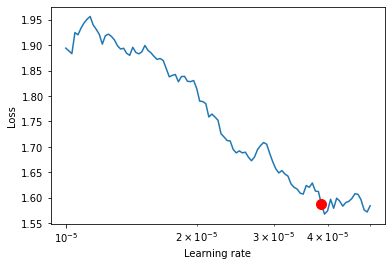

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 6.288048778873343e-05
min lr: 1e-05
max lr: 0.0005


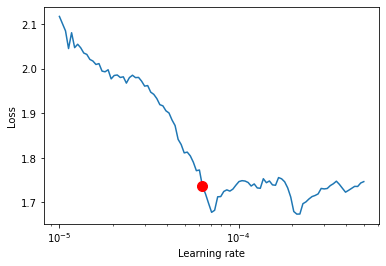

In [7]:
#6.288e-05
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 0.00014956617259811975
min lr: 1e-06
max lr: 0.009


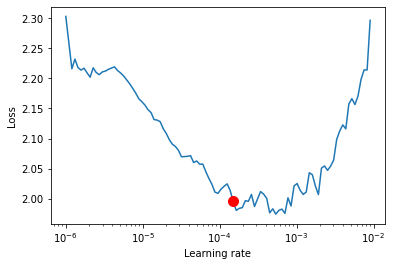

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 0.0018911689452339687
min lr: 0.001
max lr: 0.009


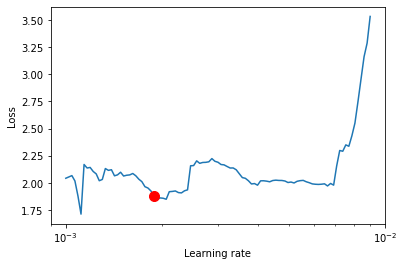

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 6.865634844764343e-05
min lr: 1e-05
max lr: 0.005


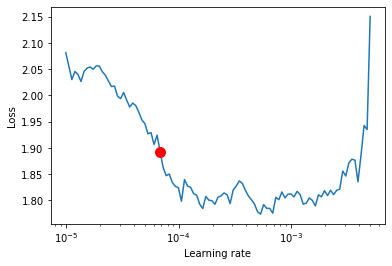

In [7]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 0.0001722525673154523
min lr: 1e-10
max lr: 0.005


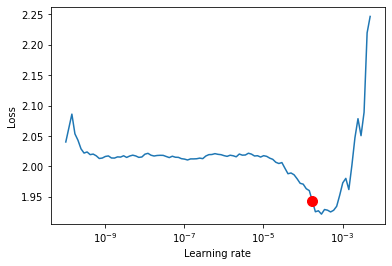

In [8]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 0.00031782371768205035
min lr: 1e-08
max lr: 0.005


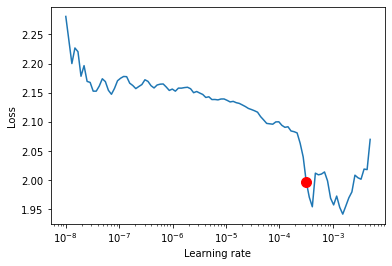

In [10]:
#0.00031782371768205035
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))